In [2]:
import pandas as pd
df = pd.read_sas('randhrs1992_2022v1.sas7bdat')

In [3]:
df.head(5)

,HHIDPN,S1HHIDPN,R1MSTAT,R1MPART,S1BMONTH,S1BYEAR,S1BDATE,S1BFLAG,S1COHBYR,S1HRSAMP,...,R8LBSATWLF,R9LBSATWLF,R10LBSATWLF,R11LBSATWLF,R12LBSATWLF,R13LBSATWLF,R14LBSATWLF,R15LBSATWLF,R16LBSATWLF,FILEVER
0,1010.0,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'X'
1,2010.0,0.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b'X'
2,3010.0,3020.0,1.0,0.0,9.0,1938.0,-7778.0,0.0,3.0,1.0,...,5.4,NaN,6.4,NaN,NaN,NaN,NaN,NaN,NaN,b'X'
3,3020.0,3010.0,1.0,0.0,1.0,1936.0,-8752.0,0.0,3.0,1.0,...,4.6,NaN,4.2,NaN,2.4,NaN,NaN,NaN,NaN,b'X'
4,10001010.0,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.8,NaN,4.8,NaN,NaN,NaN,NaN,NaN,b'X'


In [4]:
import pandas as pd
import numpy as np

# 1. CONFIGURATION: The Dictionary of Signals
# We map the "Concept" to the "RAND Variable Suffix"
DYNAMIC_VARS = {
    'BMI': 'BMI',          # Body Mass Index
    'Depression': 'CESD',  # CES-D Depression Score
    'Mobility': 'MOBILA',  # Mobility Index
    'Health': 'SHLT',      # Self-rated Health (1=Exln, 5=Poor)
    'BP_High': 'HIBP',     # High Blood Pressure Flag
    'Age': 'AGEY_E',       # Age at interview
    # THE DISEASE TARGETS
    'T_Diabetes': 'DIAB',
    'T_Heart': 'HEART',   # Heart condition
    'T_Stroke': 'STROK',  # Stroke
    'T_Lung': 'LUNG',     # Lung disease
    'T_Cancer': 'CANCRE',  # Cancer
    'T_HIBP': 'HIBP',

    # THE DISASE NO CRONICAS
    'T_Arthritis': 'ARTHR'
}

STATIC_VARS = [
    'HHIDPN',   # Unique ID
    'RAGENDER', # Gender (1=Male, 2=Female)
    'RARACEM'   # Race
]

# MAX_WAVE: RAND HRS usually goes up to Wave 15 (2020)
WAVES = range(2, 16) # Starting at 2 allows us to calculate 'lag' from wave 1 if needed

In [5]:
def create_baseline_dataset(df_raw):
    print("--- Starting Processing ---")
    
    # A. Extract Static Features (Demographics)
    # These don't change over time, so we just grab them once.
    df_static = df_raw[STATIC_VARS].copy()
    
    long_frames = []
    
    # B. Loop Through Waves to Build "Person-Period" Rows
    for wave in WAVES:
        # 1. Dynamic Variables for this Wave
        # We look for columns like 'R5BMI', 'R5CESD'
        wave_cols = {'HHIDPN': 'HHIDPN'}
        
        valid_wave = True
        for friendly_name, suffix in DYNAMIC_VARS.items():
            col_name = f"R{wave}{suffix}"
            if col_name in df_raw.columns:
                wave_cols[col_name] = friendly_name
            else:
                # If a critical variable is missing for a wave, skip the wave
                valid_wave = False
        
        if not valid_wave:
            continue
            
        # 2. Extract and Rename
        df_wave = df_raw[list(wave_cols.keys())].copy()
        df_wave = df_wave.rename(columns=wave_cols)
        df_wave['Wave'] = wave
        
        long_frames.append(df_wave)
        
    # C. Stack into Long Format
    df_long = pd.concat(long_frames, ignore_index=True)
    
    # D. Merge Static Features
    # Now every row (Person-Wave) has the person's Gender/Race attached
    df_final = pd.merge(df_long, df_static, on='HHIDPN', how='left')
    
    # Sort by Person and Time (Critical for the next step)
    df_final = df_final.sort_values(by=['HHIDPN', 'Wave'])
    
    print(f"--- Reshaping Complete. Rows: {len(df_final)} ---")
    return df_final

In [6]:
def engineer_features(df):
    # 0. Robust Sort
    df = df.sort_values(by=['HHIDPN', 'Wave'])
    
    # 1. Forward Fill (Impute missing history)
    df = df.set_index('HHIDPN')
    df = df.groupby(level=0).ffill()
    df = df.reset_index()
    
    # 2. DEFINE "CURRENT SICKNESS"
    # A person is "Sick" if they have ANY of the 5 conditions
    disease_cols = ['T_Diabetes', 'T_Heart', 'T_Stroke', 'T_Lung', 'T_Cancer', 'T_HIBP', 'T_Arthritis']
    
    # Sum the flags (if sum > 0, they are sick)
    df['Current_Chronic_Count'] = df[disease_cols].sum(axis=1)
    df['Is_Currently_Sick'] = (df['Current_Chronic_Count'] > 0).astype(int)
    
    # 3. DEFINE "FUTURE SICKNESS" (The Target)
    # Shift the "Is_Currently_Sick" column backwards by 1 wave
    df['Next_Wave_Sick'] = df.groupby('HHIDPN')['Is_Currently_Sick'].shift(-1)
    
    # 4. DEFINE "ONSET" (The Gold Medal Target)
    # We want: Currently Healthy (0) -> Future Sick (1)
    df['Y'] = 0
    mask_onset = (df['Is_Currently_Sick'] == 0) & (df['Next_Wave_Sick'] == 1)
    df.loc[mask_onset, 'Y'] = 1
    
    # 5. FILTER: The "At Risk" Cohort
    # CRITICAL: We must TRAIN only on people who are currently HEALTHY.
    # If they already have Heart Disease, we can't predict "Onset of Chronic Disease" 
    # (they already have it).
    df_clean = df[
        (df['Is_Currently_Sick'] == 0) & 
        (df['Next_Wave_Sick'].notna())
    ].copy()
    
    # 6. Weak Signals (Deltas)
    if 'BMI' in df_clean.columns:
        df_clean['Delta_BMI'] = df_clean.groupby('HHIDPN')['BMI'].diff()
    if 'Health' in df_clean.columns:
        df_clean['Delta_Health'] = df_clean.groupby('HHIDPN')['Health'].diff()
    if 'Age' in df_clean.columns and 'BMI' in df_clean.columns:
        # High BMI is worse when you are older
        df_clean['Risk_Metabolic_Age'] = df_clean['Age'] * df_clean['BMI']
        
    if 'Age' in df_clean.columns and 'Health' in df_clean.columns:
        # Poor health (high score) at old age is critical
        df_clean['Risk_Frailty_Index'] = df_clean['Age'] * df_clean['Health']

    # B. "Cumulative Damage" (Lag Features)
    # Did they have high BMI *last wave* too? (Chronic exposure)
    # We re-group to get the previous value safely
    # Note: We must be careful not to introduce leakage. 
    # Using "Shift(1)" is safe because it's PAST data.
    
    # Re-sort to be safe
    df_clean = df_clean.sort_values(by=['HHIDPN', 'Wave'])
    
    # Create Lag 1 (Value 2 years ago)
    for col in ['BMI', 'Health', 'Mobility', 'Depression']:
        if col in df_clean.columns:
            df_clean[f'{col}_Lag1'] = df_clean.groupby('HHIDPN')[col].shift(1)
            
            # Create "Acceleration" (Delta of the Delta)
            # Are they getting worse *faster*?
            # Current Delta = Val_t - Val_t-1
            # Past Delta = Val_t-1 - Val_t-2
            # Acceleration = Current Delta - Past Delta
            
            # To do this simply: Diff the Delta columns you already made
            if f'Delta_{col}' in df_clean.columns:
                df_clean[f'Accel_{col}'] = df_clean.groupby('HHIDPN')[f'Delta_{col}'].diff()

    # C. "Flags" (Extreme Events)
    # Sometimes it's not the number, it's the specific event.
    if 'Mobility' in df_clean.columns:
        # Sudden loss of mobility (Switch from 0 to >0)
        df_clean['Mobility_Crisis'] = ((df_clean['Mobility'] > 0) & (df_clean['Mobility'].shift(1) == 0)).astype(int)

    return df_clean
    return df_clean

In [7]:
# DIAGNOSTIC: Check Wave 10 (a stable middle wave)
test_wave = 10
print(f"--- Checking Variables for Wave {test_wave} ---")

for friendly, suffix in DYNAMIC_VARS.items():
    target_col = f"R{test_wave}{suffix}"
    if target_col in df.columns:
        print(f"[OK] Found: {target_col}")
    else:
        print(f"[MISSING] Could not find: {target_col}") 
        # Check if it's a case sensitivity issue (SAS sometimes loads lowercase)
        if target_col.lower() in df.columns:
             print(f"      -> But found lowercase '{target_col.lower()}'. SAS import issue!")

--- Checking Variables for Wave 10 ---
[OK] Found: R10BMI
[OK] Found: R10CESD
[OK] Found: R10MOBILA
[OK] Found: R10SHLT
[OK] Found: R10HIBP
[OK] Found: R10AGEY_E
[OK] Found: R10DIAB
[OK] Found: R10HEART
[OK] Found: R10STROK
[OK] Found: R10LUNG
[OK] Found: R10CANCRE
[OK] Found: R10HIBP
[OK] Found: R10ARTHR


In [8]:
df_raw = df
df_long = create_baseline_dataset(df_raw)

# 2. Engineer
df_train = engineer_features(df_long)

# 3. Sanity Check (ALWAYS do this)
event_rate = df_train['Y'].mean()
print(f"Baseline Event Rate: {event_rate:.2%}")
# Expected output: Between 2% and 5% for DISEASE Onset over 2 years.

--- Starting Processing ---
--- Reshaping Complete. Rows: 633276 ---
Baseline Event Rate: 11.26%


In [11]:
from sklearn.model_selection import GroupShuffleSplit

# ---------------------------------------------------------
# 1. SETUP FEATURES & TARGET (CORRECTED)
# ---------------------------------------------------------
# A. Metadata & Targets (Do not train on these)
ignore_cols = [
    'HHIDPN',                 # The ID
    'Wave',                   # The Time
    'Y',                      # The Target
    'Next_Wave_Sick',         # Future Leaker (Intermediate step for Y)
    'Is_Currently_Sick',      # Current Status (Intermediate step)
    'Current_Chronic_Count',  # Derived score
    'RAGENDER', 'RARACEM'     # Keep these ONLY if you want demographics as features. 
                              # (Usually yes, so remove from this list if you want to train on them)
]

# B. Leakage Columns (The Raw Disease Flags)
# We must NOT train on "Does he have Diabetes?" if we are predicting "Will he get sick?"
# These specific names come from your DYNAMIC_VARS dictionary
leakage_cols = [
    'T_Diabetes', 
    'T_Heart', 
    'T_Stroke', 
    'T_Lung', 
    'T_Cancer', 
    'T_Psych', 
    'T_Arthritis',
    'T_HIBP' # Decide: Is HIBP a target (Leak) or a Risk Factor (Feature)? 
             # If it's a target, keep it here. If it's a predictor, remove it from here.
]

# C. Feature Selection
# "Give me everything in the dataframe that is NOT a metadata column AND NOT a leakage column"
features = [c for c in df_train.columns if c not in ignore_cols and c not in leakage_cols]

print(f"--- Feature Audit ---")
print(f"Total Columns: {len(df_train.columns)}")
print(f"Training Features ({len(features)}): {features}")

# ---------------------------------------------------------
# 2. STRICT GROUP SPLIT (Anti-Leakage)
# ---------------------------------------------------------
# (This part remains the same, but ensuring Y is int is good practice)
df_train['Y'] = df_train['Y'].astype(int)

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(df_train, df_train['Y'], groups=df_train['HHIDPN']))

X_train = df_train.iloc[train_idx][features]
y_train = df_train.iloc[train_idx]['Y']
X_val = df_train.iloc[val_idx][features]
y_val = df_train.iloc[val_idx]['Y']

--- Feature Audit ---
Total Columns: 31
Training Features (16): ['BMI', 'Depression', 'Mobility', 'Health', 'Age', 'Delta_BMI', 'Delta_Health', 'Risk_Metabolic_Age', 'Risk_Frailty_Index', 'BMI_Lag1', 'Accel_BMI', 'Health_Lag1', 'Accel_Health', 'Mobility_Lag1', 'Depression_Lag1', 'Mobility_Crisis']


--- Training Configuration ---
Total Rows: 256670
Feature Count: 16
Features: ['BMI', 'Depression', 'Mobility', 'Health', 'Age', 'Delta_BMI', 'Delta_Health', 'Risk_Metabolic_Age', 'Risk_Frailty_Index', 'BMI_Lag1', 'Accel_BMI', 'Health_Lag1', 'Accel_Health', 'Mobility_Lag1', 'Depression_Lag1', 'Mobility_Crisis']
Train Size: 205174 | Val Size: 51496
Val Event Rate: 11.19%
0:	test: 0.6747283	best: 0.6747283 (0)	total: 163ms	remaining: 5m 25s
200:	test: 0.6817091	best: 0.6817865 (187)	total: 2.87s	remaining: 25.7s
400:	test: 0.6816953	best: 0.6819769 (300)	total: 5.57s	remaining: 22.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6819769453
bestIteration = 300

Shrink model to first 301 iterations.

--- FINAL RESULTS ---
ROC-AUC Score: 0.6820
Max F2 Score:  0.4037
Best Threshold: 0.41

--- TOP 10 PREDICTORS ---
               Feature  Importance
10           Accel_BMI   21.372643
8   Risk_Frailty_Index   10.428569
5            Delta_BMI    8.697556
7   Risk_Metaboli

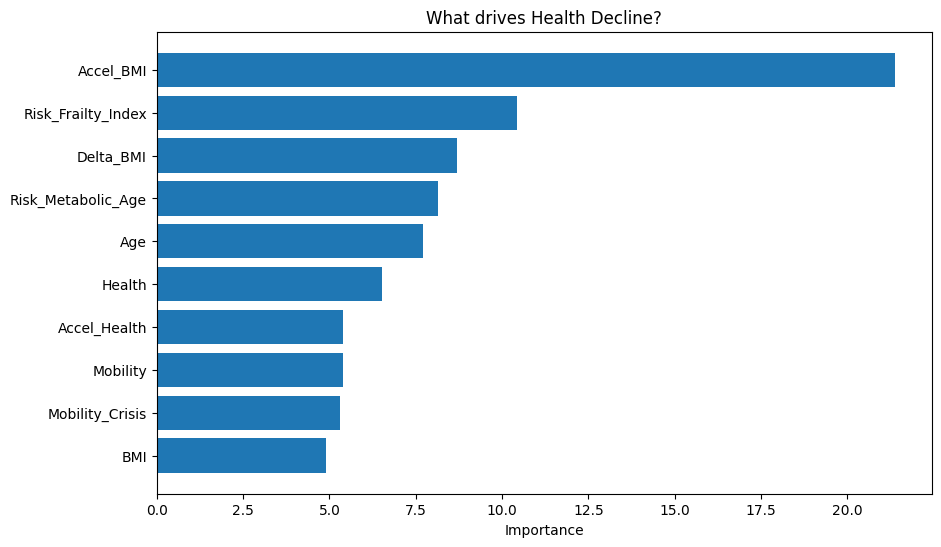

In [13]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, fbeta_score, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# 1. ROBUST FEATURE SELECTION
# ---------------------------------------------------------
# A. Define columns to IGNORE (Metadata & Intermediate steps)
ignore_cols = [
    'HHIDPN',                 # The ID
    'Wave',                   # The Time
    'Y',                      # The Target
    'Next_Wave_Sick',         # Future Leaker
    'Is_Currently_Sick',      # Current Status
    'Current_Chronic_Count',  # Derived score
    'RAGENDER', 'RARACEM'     # Keep these ONLY if you want demographics as features
]

# B. Define LEAKAGE columns (The raw disease flags)
# These are the columns starting with 'T_' that we used to build the target.
# We cannot use "Has Cancer" to predict "Will get Sick" if we filtered them out.
# (Note: If you want to use T_HIBP as a feature, remove it from this list!)
leakage_cols = [col for col in df_train.columns if col.startswith('T_')]

# C. Construct the Final Feature List
features = [c for c in df_train.columns if c not in ignore_cols and c not in leakage_cols]

print(f"--- Training Configuration ---")
print(f"Total Rows: {len(df_train)}")
print(f"Feature Count: {len(features)}")
print(f"Features: {features}")

# ---------------------------------------------------------
# 2. ANTI-LEAKAGE SPLITTING
# ---------------------------------------------------------
# We split by HHIDPN so a person is entirely in Train OR entirely in Val
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(df_train, df_train['Y'], groups=df_train['HHIDPN']))

X_train = df_train.iloc[train_idx][features]
y_train = df_train.iloc[train_idx]['Y'].astype(int)
X_val = df_train.iloc[val_idx][features]
y_val = df_train.iloc[val_idx]['Y'].astype(int)

print(f"Train Size: {len(X_train)} | Val Size: {len(X_val)}")
print(f"Val Event Rate: {y_val.mean():.2%}")

# ---------------------------------------------------------
# 3. TRAIN CATBOOST (Optimized for 11% Imbalance)
# ---------------------------------------------------------
model = CatBoostClassifier(
    iterations=2000,           # More trees for complex relations
    learning_rate=0.02,        # Slow and steady wins the race
    depth=6,                   # Standard depth
    l2_leaf_reg=4,             # Higher reg to prevent overfitting on noise
    loss_function='Logloss',
    eval_metric='AUC',
    scale_pos_weight=8,        # Tuned for ~11% Event Rate (1:8 ratio)
    early_stopping_rounds=200, # Give it time to recover
    verbose=200,
    allow_writing_files=False,
    random_seed=42
)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)

# ---------------------------------------------------------
# 4. EVALUATION (F2 Optimization)
# ---------------------------------------------------------
probs = model.predict_proba(X_val)[:, 1]

# Automatic Threshold Tuning for F2 Score
thresholds = np.arange(0.1, 0.9, 0.01)
f2_scores = []

for thresh in thresholds:
    preds = (probs > thresh).astype(int)
    score = fbeta_score(y_val, preds, beta=2)
    f2_scores.append(score)

best_f2 = max(f2_scores)
best_thresh = thresholds[np.argmax(f2_scores)]

print(f"\n--- FINAL RESULTS ---")
print(f"ROC-AUC Score: {roc_auc_score(y_val, probs):.4f}")
print(f"Max F2 Score:  {best_f2:.4f}")
print(f"Best Threshold: {best_thresh:.2f}")

# ---------------------------------------------------------
# 5. EXPLAINABILITY (The "Weak Signals")
# ---------------------------------------------------------
feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- TOP 10 PREDICTORS ---")
print(feat_imp.head(10))

# Quick Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'].head(10)[::-1], feat_imp['Importance'].head(10)[::-1])
plt.title("What drives Health Decline?")
plt.xlabel("Importance")
plt.show()